# Anomaly detection

<a id='table'></a>
## Table of Contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#DW&EDA">Data Wrangling & Exploratory Data Analysis</a></li>
<li><a href="#outliers_frac">Outliers Fraction Identification Using IQR</a></li>
<li><a href="#clustering">Clustering-based Anomaly Detection</a></li>
<li><a href="#isolation_forest">Isolation Forest</a></li>
<li><a href="#svm">Support Vector Machine Technique</a></li>
<li><a href="#gaussian_distr">Anomaly Detection with Gaussian Distribution</a></li>
<li><a href="#summary">Summary</a></li>
<li><a href="#ref">References</a></li>
</ul>

<a id='intro'></a>
## Introduction

**Anomaly detection** also known as outlier detection is a data mining process used to determine types of anomalies found in a dataset and to determine details about their occurrences. Automatic anomaly detection is critical in today’s world where the sheer volume of data makes it impossible to tag outliers manually. Auto anomaly detection has a wide range of applications such as fraud detection, system health monitoring, fault detection, and event detection systems in sensor networks, and so on.

### Motivation

I was curious to see how different unsupervised ML algorithms identify anomalies in a dataset.

### Data

I used a dataset from [Personalize Expedia Hotel Searches](https://www.expedia.com), which can be found [here](https://www.kaggle.com/c/expedia-personalized-sort/data).

For a simplicity of the analysis I selected:
* train.csv;
* one single hotel, which has the largest number of data points (prop_id = 124342);
* visitor_location_country_id = 219;
* search_room_count = 1;
* key features for the analysis: date_time, price_usd, srch_booking_window, srch_saturday_night_bool.

<a id='DW&EDA'></a>
## Data Wrangling & Exploratory Data Analysis

In [194]:
# Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

In [195]:
df_expedia = pd.read_csv('test.csv')
df_expedia.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff
0,2,2012-11-05 21:28:38,15,55,NaN,NaN,98,3105,3,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2012-11-05 21:28:38,15,55,NaN,NaN,98,6399,3,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2012-11-05 21:28:38,15,55,NaN,NaN,98,7374,4,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,2012-11-05 21:28:38,15,55,NaN,NaN,98,7771,3,4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,2012-11-05 21:28:38,15,55,NaN,NaN,98,12938,3,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [196]:
df_expedia['prop_id'].value_counts()

124342    3180
104517    3172
40279     3055
68420     3049
59781     3041
          ... 
57234        1
62839        1
8726         1
530          1
9873         1
Name: prop_id, Length: 132888, dtype: int64

In [197]:
df = df_expedia.loc[df_expedia['prop_id'] == 124342]
df.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff
689,50,2013-06-22 22:27:56,5,219,NaN,NaN,219,124342,4,4.0,...,11.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,12.0
920,76,2013-03-07 16:44:24,5,219,NaN,NaN,219,124342,4,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
3775,341,2013-03-31 17:31:28,5,219,NaN,NaN,219,124342,4,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6219,596,2013-04-07 08:05:13,5,219,NaN,NaN,219,124342,4,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
6947,657,2013-03-25 17:35:10,5,219,NaN,NaN,219,124342,4,4.0,...,33.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN


In [198]:
df['visitor_location_country_id'].value_counts()

219    2341
100     303
220      94
55       93
216      55
       ... 
202       1
204       1
206       1
230       1
106       1
Name: visitor_location_country_id, Length: 63, dtype: int64

In [199]:
df['srch_room_count'].value_counts()

1    2752
2     354
3      53
4       8
6       6
8       3
7       2
5       2
Name: srch_room_count, dtype: int64

In [200]:
# Let's choose the most popular room type and the country id
df = df.loc[df['srch_room_count'] == 1]
df = df.loc[df['visitor_location_country_id'] == 219]

In [201]:
df['date_time'].min(), df['date_time'].max()

('2012-11-01 09:01:25', '2013-06-30 23:27:55')

In [202]:
df = df[['date_time', 'price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2020 entries, 3775 to 6622237
Data columns (total 4 columns):
date_time                   2020 non-null object
price_usd                   2020 non-null float64
srch_booking_window         2020 non-null int64
srch_saturday_night_bool    2020 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 78.9+ KB


**date_time** is in object format, which should be changed to datetime format

In [204]:
# Changing the format of date_time column
df['date_time'] = pd.to_datetime(df['date_time'])

# Sorting values based on the time and getting some statistics on the price data
df = df.sort_values('date_time')
df['price_usd'].describe()

count    2020.000000
mean      122.655272
std        59.152402
min        42.000000
25%        75.000000
50%       110.000000
75%       155.000000
max       412.000000
Name: price_usd, dtype: float64

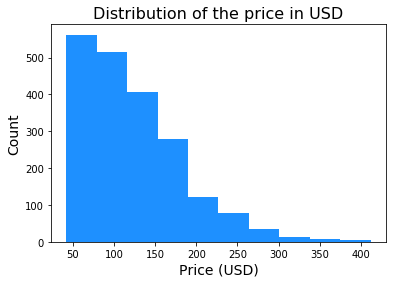

In [205]:
# histogram for price
plt.hist(data=df, x='price_usd', color='dodgerblue')
plt.xlabel('Price (USD)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title("Distribution of the price in USD", fontsize=16);

It's clear that the histogram is **right skewed**, which means that the **mean value is higher than the median** value for the price of renting of a one room apartment in the selected area.

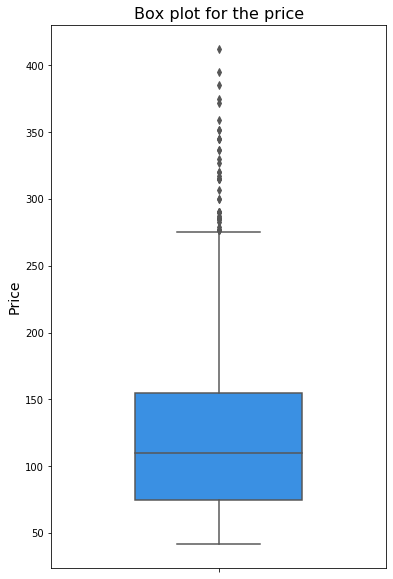

In [206]:
# Building a box plot for price
plt.figure(figsize=(6,10))
bplot = sns.boxplot(y='price_usd', data=df, width=0.5, color='dodgerblue')
bplot.axes.set_title("Box plot for the price",fontsize=16)
bplot.set_ylabel("Price", fontsize=14)
bplot.tick_params(labelsize=10)

According to the data from the box plot, there are some expected **outliers** in the dataset

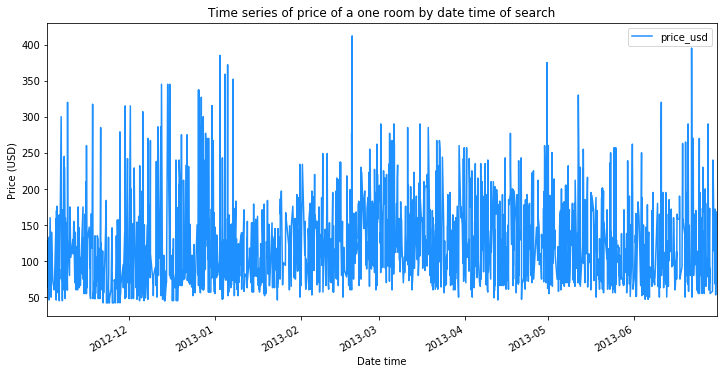

In [207]:
# plot the time series data
df.plot(x='date_time', y='price_usd', figsize=(12,6), color='dodgerblue')
plt.xlabel('Date time')
plt.ylabel('Price (USD)')
plt.title('Time series of price of a one room by date time of search');

In [208]:
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool
4701245,2012-11-01 09:01:25,120.0,1,1
3795335,2012-11-01 09:36:30,67.0,28,1
2964783,2012-11-01 10:14:53,64.0,3,0
6403595,2012-11-01 12:20:51,117.0,1,1
4404057,2012-11-01 14:38:18,128.0,15,1


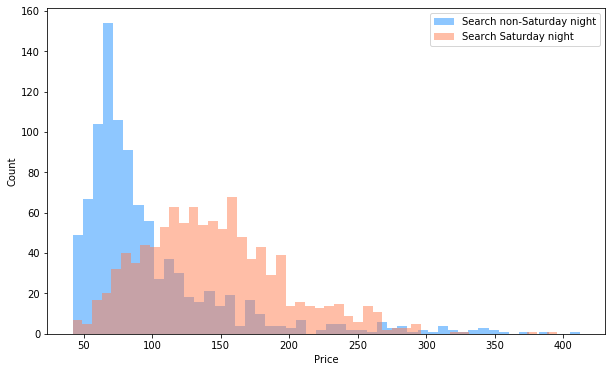

In [209]:
# Let's have a look on the difference between the search on Saturday night and non-Saturday night
a = df.loc[df['srch_saturday_night_bool'] == 0, 'price_usd']
b = df.loc[df['srch_saturday_night_bool'] == 1, 'price_usd']
plt.figure(figsize=(10, 6))
plt.hist(a, bins = 50, alpha=0.5, label='Search non-Saturday night', color='dodgerblue')
plt.hist(b, bins = 50, alpha=0.5, label='Search Saturday night', color='coral')
plt.legend(loc='upper right')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show();

The price is more stable and lower on non-Saturday night than on a Saturday night

In [210]:
df['srch_saturday_night_bool'].value_counts()

1    1046
0     974
Name: srch_saturday_night_bool, dtype: int64

I'm curious about **when the searching platform gets more visitors**. For that I created a dataframe (df_copy) with the following parameters: search_date, search_hour_of_day, search_day_of_week, search_month.
 - df_copy was created in order to keep the main features separated to perform further analysis.

In [211]:
df_copy = df.copy()
df_copy['search_date'] = df_copy.date_time.dt.strftime('%Y-%m-%d')
df_copy['search_hour_of_day'] = df_copy.date_time.dt.strftime('%H')
df_copy['search_day_of_week'] = df_copy.date_time.dt.strftime('%A')
df_copy['search_month'] = df_copy.date_time.dt.strftime('%B')
df_copy.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool,search_date,search_hour_of_day,search_day_of_week,search_month
4701245,2012-11-01 09:01:25,120.0,1,1,2012-11-01,09,Thursday,November
3795335,2012-11-01 09:36:30,67.0,28,1,2012-11-01,09,Thursday,November
2964783,2012-11-01 10:14:53,64.0,3,0,2012-11-01,10,Thursday,November
6403595,2012-11-01 12:20:51,117.0,1,1,2012-11-01,12,Thursday,November
4404057,2012-11-01 14:38:18,128.0,15,1,2012-11-01,14,Thursday,November


Let's build a heat map to see when the service gets more clients 😊

In [212]:
# First, let's sort the dataframe based on the day of a week
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_copy['search_day_of_week'] = pd.Categorical(df_copy['search_day_of_week'], categories=cats, ordered=True)
df_copy = df_copy.sort_values('search_day_of_week')

<Figure size 432x288 with 0 Axes>

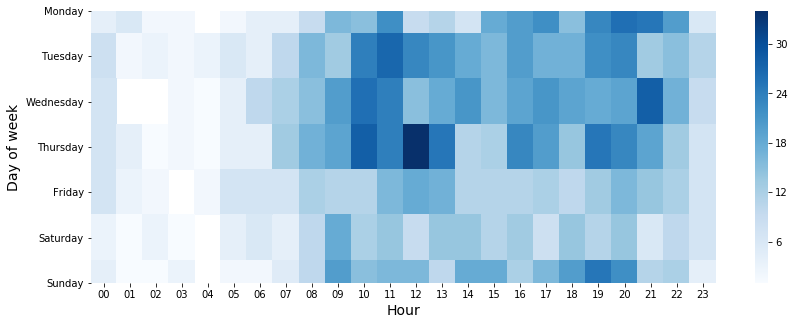

In [213]:
plt.suptitle('Monthly usage of the service', fontsize=16);

plt.figure(figsize = (14,5));
ct_counts = df_copy.groupby(['search_day_of_week', 'search_hour_of_day']).size().reset_index(name='count');
ct_counts = ct_counts.pivot(index='search_day_of_week', columns='search_hour_of_day', values='count');
sns.heatmap(ct_counts, cmap="Blues");
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Day of week', fontsize=14);

It's interesting, that the service is more popular from Monday to Thursday from 8-9 AM to ~ 9 PM.

Also, it's interesting to see which month is more popular for a search

In [214]:
df_copy.search_month.value_counts()

March       287
December    277
January     269
May         262
November    233
June        232
February    231
April       229
Name: search_month, dtype: int64

There is no large difference between all the months. However, we can say that for Expedia people tend to search more in March rather than in April.

The distribution between non-Saturday night and Saturday night searches is almost equal

In [215]:
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool
4701245,2012-11-01 09:01:25,120.0,1,1
3795335,2012-11-01 09:36:30,67.0,28,1
2964783,2012-11-01 10:14:53,64.0,3,0
6403595,2012-11-01 12:20:51,117.0,1,1
4404057,2012-11-01 14:38:18,128.0,15,1


For further analysis "price_usd", "srch_booking_window" and "srch_saturday_night_bool" are selected to find anomalies in the dataset.

<a id='outliers_frac'></a>
## Outliers Fraction Identification Using IQR

In order to identify outliers using below explaied techniques we have to apply outlier fraction to the models. Therefore, I decided to calculate **the number of outliers** in the dataset using **Interquartile Range (IQR)** score.

The IQR, is just the width of the box in the box-and-whisker plot. That is, IQR = Q3 – Q1 . The IQR can be used as a measure of how spread-out the values are. The IQR tells how spread out the "middle" values are; it can also be used to tell when some of the other values are "too far" from the central value. These "too far away" points are called "outliers", because they "lie outside" the range in which we expect them. That is, if a data point is below Q1 – 1.5×IQR or above Q3 + 1.5×IQR, it is viewed as being too far from the central values to be reasonable. 

In [216]:
# Calculating IQR
Q1_price = df['price_usd'].quantile(0.25)
Q3_price = df['price_usd'].quantile(0.75)
IQR = Q3_price - Q1_price
lower_bound = Q1_price - (IQR * 1.5)
upper_bound = Q3_price + (IQR * 1.5)

In [217]:
# Let us calculate the outlier fraction for the dataset looking at the price parameter
out_num = df['price_usd'][df['price_usd'] < lower_bound].count() + df['price_usd'][df['price_usd'] > upper_bound].count()
outliers_fraction = out_num / len(df)
outliers_fraction

0.020792079207920793

We have about 2% of outliers in the dataset

<a id='clustering'></a>
## Clustering-based Anomaly Detection

### k-means algorithm

k-means is a widely used clustering algorithm. A cluster refers to a collection of data points aggregated together because of certain similarities. The ‘means’ in the K-means refers to averaging of the data; that is, finding the centroid.

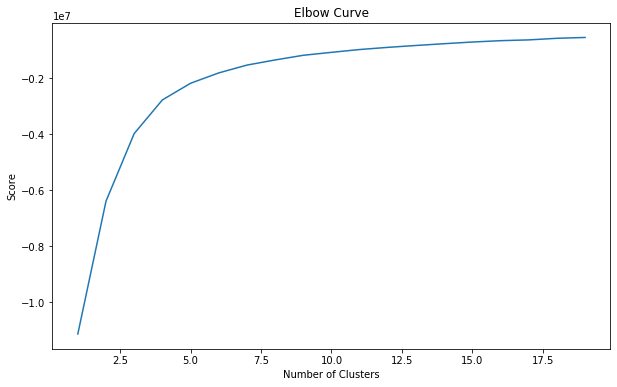

In [218]:
# Take useful feature and standardize them
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

From the above elbow curve, we see that the graph levels off after 10 clusters, implying that addition of more clusters do not explain much more of the variance in our relevant variable; in this case price_usd.

We set n_clusters=10, and upon generating the k-means output use the data to plot the 3D clusters:

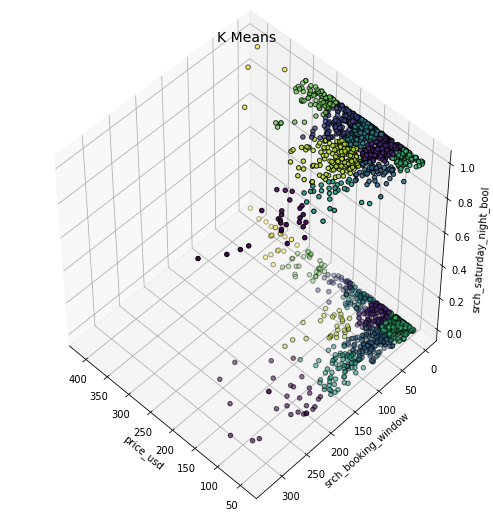

In [219]:
X = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
km.predict(X)
labels = km.labels_

#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("price_usd")
ax.set_ylabel("srch_booking_window")
ax.set_zlabel("srch_saturday_night_bool")
plt.title("K Means", fontsize=14);

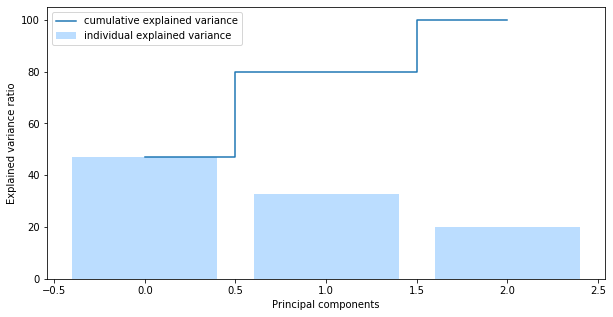

In [220]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = data.values
X_std = StandardScaler().fit_transform(X)

#Calculating Eigenvecors and eigenvalues of Covariance matrix
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'dodgerblue')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

We see that the first component explains almost 50% of the variance. The second component explains over 30%. However, we've got to notice that almost none of the components are really negligible. The first 2 components contain over 80% of the information. So, we will set n_components=2.

In [221]:
# Take useful feature and standardize them
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)

# reduce to 2 important features
pca = PCA(n_components=2)
data = pca.fit_transform(data)

# standardize these 2 new features
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [222]:
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
df['cluster'] = kmeans[9].predict(data)
df.index = data.index
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

3    436
1    379
7    276
8    264
2    217
5    148
9    123
0     93
4     47
6     37
Name: cluster, dtype: int64

In [223]:
# Let's have a look on the obtained dataset
df.head()

,date_time,price_usd,srch_booking_window,srch_saturday_night_bool,cluster,principal_feature1,principal_feature2
0,2012-11-01 09:01:25,120.0,1,1,1,0.666896,-0.526566
1,2012-11-01 09:36:30,67.0,28,1,7,0.030416,0.008194
2,2012-11-01 10:14:53,64.0,3,0,3,-1.048326,-1.027723
3,2012-11-01 12:20:51,117.0,1,1,1,0.636957,-0.529453
4,2012-11-01 14:38:18,128.0,15,1,1,0.690961,-0.215136


### Clustering approach

The underline assumption in the clustering approach is that if we cluster the data, normal data will belong to clusters while anomalies will not belong to any clusters or belong to small clusters.

In [224]:
# return Series of distance between each point and its distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[9])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)

/Users/aigerimshopenova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


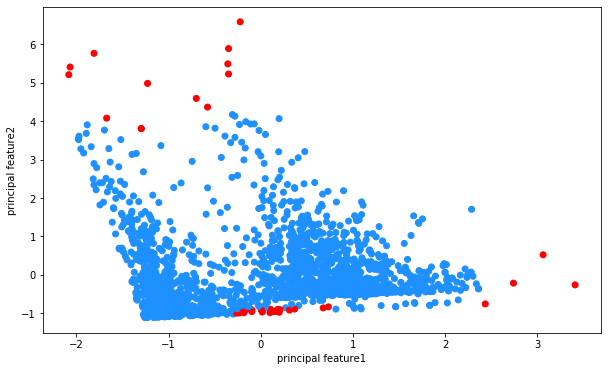

In [225]:
# Plot the data
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'dodgerblue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

In [226]:
df.anomaly1.value_counts()

0    1978
1      42
Name: anomaly1, dtype: int64

We got 20 anomalies in the dataset using k-means clustering

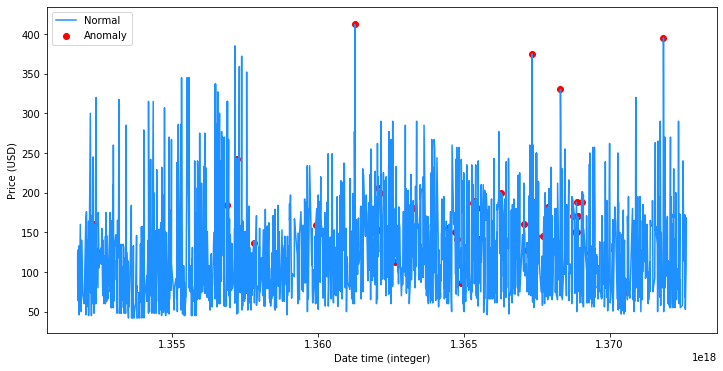

In [244]:
df = df.sort_values('date_time')
df['date_time_int'] = df.date_time.astype(np.int64)
fig, ax = plt.subplots(figsize=(12,6))

a = df.loc[df['anomaly1'] == 1, ['date_time_int', 'price_usd']] #anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='dodgerblue', label='Normal')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label='Anomaly')
plt.xlabel('Date time (integer)')
plt.ylabel('Price (USD)')
plt.legend()
plt.show();

The anomalies belong to low to medium value ranges for the price

Visualization of anomaly with re-partition

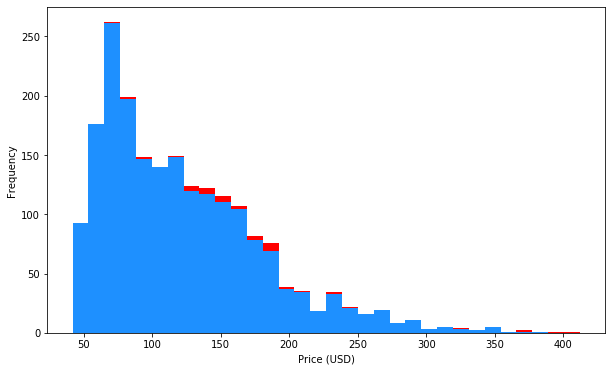

In [228]:
a = df.loc[df['anomaly1'] == 0, 'price_usd']
b = df.loc[df['anomaly1'] == 1, 'price_usd']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['dodgerblue', 'red'])
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show();

With K-means clustering approach anomalies are found for apartments with ~ midium and high range of prices.

<a id='isolation_forest'></a>
## Isolation Forest

Isolation forest returns the anomaly score of each sample by ‘isolating’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

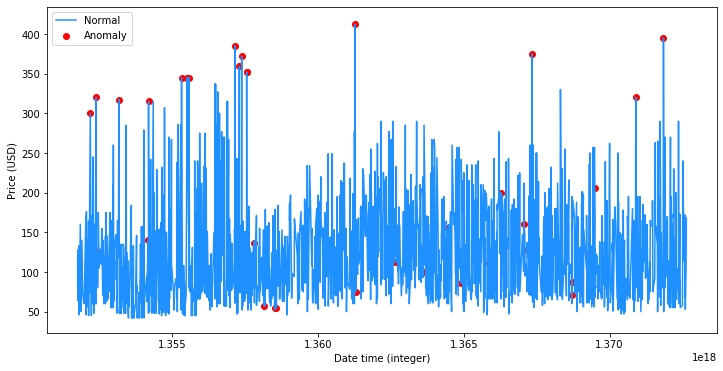

In [245]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)

df['anomaly2'] = pd.Series(model.predict(data))
# df['anomaly2'] = df['anomaly2'].map( {1: 0, -1: 1} )

fig, ax = plt.subplots(figsize=(12,6))

a = df.loc[df['anomaly2'] == -1, ['date_time_int', 'price_usd']] #anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='dodgerblue', label = 'Normal')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label = 'Anomaly')
plt.legend()
plt.xlabel('Date time (integer)')
plt.ylabel('Price (USD)')
plt.show();

In [230]:
df['anomaly2'].value_counts()

 1    1978
-1      42
Name: anomaly2, dtype: int64

We got 21 anomalies using Isloation Forest algorithm

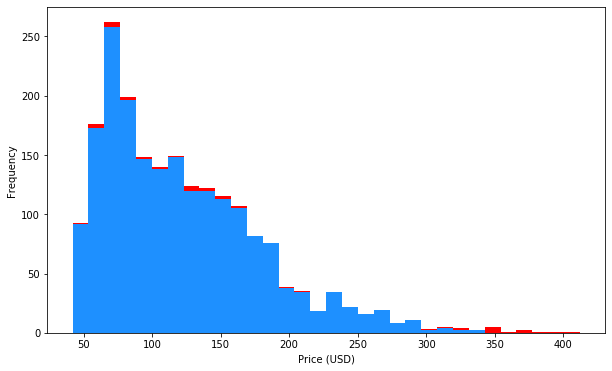

In [231]:
# visualisation of anomaly with avg price repartition
a = df.loc[df['anomaly2'] == 1, 'price_usd']
b = df.loc[df['anomaly2'] == -1, 'price_usd']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['dodgerblue', 'red'])
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show();

The anomalies range for Isolation Forest technique belongs to both mid and high ranges of price for a rent. However, Isolation Forest techniques gives more anomalies in a higher range of prices than k-means clustering.

<a id='svm'></a>
## Support Vector Machine Technique

A support vector machine (SVM) is a supervised machine learning model that uses classification algorithms for two-group classification problems. After giving an SVM model sets of labeled training data for each  category, they’re able to categorize new text. A SVM is typically associated with supervised learning, but OneClassSVM can be used to identify anomalies as an unsupervised problems.

### One Class SVM

A One-Class Support Vector Machine is an unsupervised learning algorithm that is trained only on the ‘normal’ data.
It learns the boundaries of these points and is therefore able to classify any points that lie outside the boundary as, you guessed it, outliers.

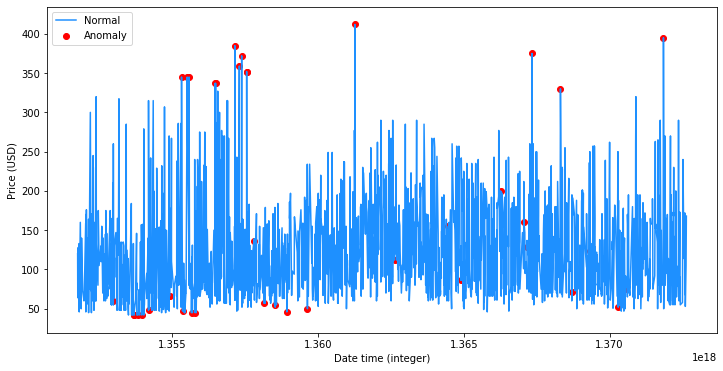

In [246]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train oneclassSVM 
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(data)
 
df['anomaly3'] = pd.Series(model.predict(data))
# df['anomaly3'] = df['anomaly3'].map( {1: 0, -1: 1} )
fig, ax = plt.subplots(figsize=(12,6))

a = df.loc[df['anomaly3'] == -1, ['date_time_int', 'price_usd']] #anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='dodgerblue', label ='Normal')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label = 'Anomaly')
plt.legend()
plt.xlabel('Date time (integer)')
plt.ylabel('Price (USD)')
plt.show();

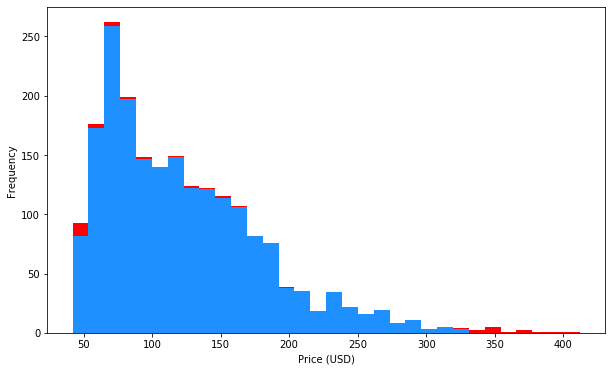

In [233]:
a = df.loc[df['anomaly3'] == 1, 'price_usd']
b = df.loc[df['anomaly3'] == -1, 'price_usd']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['dodgerblue', 'red'])
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show();

With One Class SVM we could find anomalies for low, mid and high price ranges of a rent.

<a id='gaussian_distr'></a>
## Anomaly Detection with Gaussian Distribution

Gaussian distribution is also called normal distribution. We will be using the Gaussian distribution to develop an anomaly detection algorithm, that is, we’ll assume that our data are normally distributed. This’s an assumption that cannot hold true for all data sets, yet when it does, it proves an effective method for spotting outliers.

Scikit-Learn’s covariance.EllipticEnvelope is a function that tries to figure out the key parameters of our data’s general distribution by assuming that our entire data is an expression of an underlying multivariate Gaussian distribution. 

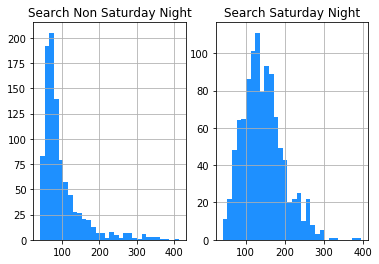

In [234]:
df_class0 = df.loc[df['srch_saturday_night_bool'] == 0, 'price_usd']
df_class1 = df.loc[df['srch_saturday_night_bool'] == 1, 'price_usd']

fig, axs = plt.subplots(1,2)
df_class0.hist(ax=axs[0], bins=30, color='dodgerblue', label='non-Saturday night')
df_class1.hist(ax=axs[1], bins=30, color='dodgerblue', label='Saturday night');
axs[0].set_title("Search Non Saturday Night")
axs[1].set_title("Search Saturday Night");

In [235]:
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

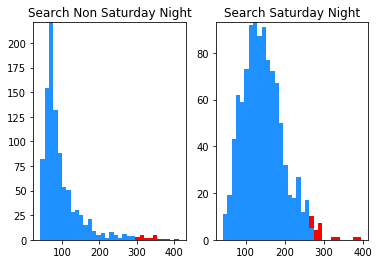

In [236]:
# plot the price repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'price_usd']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'price_usd']

a2 = df_class1.loc[df_class1['anomaly'] == 1, 'price_usd']
b2 = df_class1.loc[df_class1['anomaly'] == -1, 'price_usd']

fig, axs = plt.subplots(1,2)
axs[0].hist([a0,b0], bins=32, stacked=True, color=['dodgerblue', 'red'])
axs[1].hist([a2,b2], bins=32, stacked=True, color=['dodgerblue', 'red'])
axs[0].set_title("Search Non Saturday Night")
axs[1].set_title("Search Saturday Night")
plt.show();

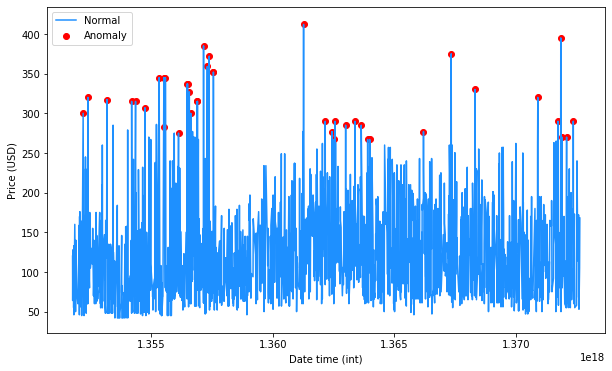

In [247]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1])
df['anomaly5'] = df_class['anomaly']
# df['anomaly5'] = np.array(df['anomaly22'] == -1).astype(int)
fig, ax = plt.subplots(figsize=(10, 6))
a = df.loc[df['anomaly5'] == -1, ('date_time_int', 'price_usd')] #anomaly
ax.plot(df['date_time_int'], df['price_usd'], color='dodgerblue', label='Normal')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label='Anomaly')
plt.xlabel('Date time (int)')
plt.ylabel('Price (USD)')
plt.legend()
plt.show();

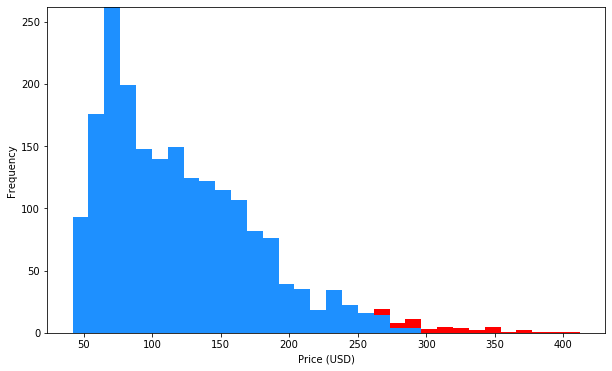

In [251]:
a = df.loc[df['anomaly5'] == 1, 'price_usd']
b = df.loc[df['anomaly5'] == -1, 'price_usd']

fig, axs = plt.subplots(figsize=(10, 6))
axs.hist([a,b], bins=32, stacked=True, color=['dodgerblue', 'red'])
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show();

It's interesting that with Gaussian Distribution method we got outliers in the upper range of price, while for other techinques we got a distribution of outliers within different ranges.

<a id='summary'></a>
## Summary

The price anomaly detection was done using 4 different methods (K-means clustering, Isolation Forest, One Class SVM, Gaussian Distribution (EllipticEnvelope)). It is clear that the methods provide different results such as:
* With K-means clustering approach anomalies are found for apartments with ~ midium and high range of prices;
* The anomalies range for Isolation Forest technique belongs to both mid and high ranges of price for a rent. However, Isolation Forest techniques gives more anomalies in a higher range of prices than k-means clustering;
* With One Class SVM we could find anomalies for low, mid and high price ranges of a rent. Moreover, this is the only method which gives anomalies for a low range prices;
* With Gaussian Distribution method we got outliers in the upper range of price, while for other techinques we got a distribution of outliers within different ranges.

After building the models, we have no idea how well it is doing as we have nothing to test it against. Hence, the results of those methods need to be tested in the field before placing them in the critical path.

<a id='ref'></a>
## References

1. [Time Series of Price Anomaly Detection](https://towardsdatascience.com/time-series-of-price-anomaly-detection-13586cd5ff46)
2. [An Introduction to Support Vector Machines (SVM)](https://monkeylearn.com/blog/introduction-to-support-vector-machines-svm/)
3. [5 Ways to Find Outliers in Your Data](https://statisticsbyjim.com/basics/outliers/)
4. [Identifying outliers with the 1.5xIQR rule](https://www.khanacademy.org/math/statistics-probability/summarizing-quantitative-data/box-whisker-plots/a/identifying-outliers-iqr-rule>) 
5. [Best clustering algorithms for anomaly detection](https://towardsdatascience.com/best-clustering-algorithms-for-anomaly-detection-d5b7412537c8)
6. [How to use machine learning for anomaly detection and condition monitoring](https://towardsdatascience.com/how-to-use-machine-learning-for-anomaly-detection-and-condition-monitoring-6742f82900d7) 
7. [Anomaly Detection in Python with Gaussian Mixture Models](https://towardsdatascience.com/understanding-anomaly-detection-in-python-using-gaussian-mixture-model-e26e5d06094b).

Go to <a href="#table">Table of Contents</a>